In [241]:
import oandapyV20.endpoints.instruments as instruments
import oandapyV20.endpoints.pricing as pricing
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.trades as trades
import pandas as pd
import oandapyV20 

import numpy as np
import seaborn as sns 
import quantstats as qs 
import datetime 
import matplotlib.pyplot as plt 
%matplotlib inline 



In [242]:
# Account information
OANDA_ACCESS_TOKEN = "987464a00c47a9b186fcc7a93a9404a6-bf2ecb97ae681e4edeb529adef404b09"
ACCOUNT_ID = "101-001-8028197-001"
access_token = OANDA_ACCESS_TOKEN
accountID = ACCOUNT_ID
client = oandapyV20.API(access_token=access_token)
API_KEY = access_token

In [243]:
# Instrument (USDJPY)
instrument = "USD_JPY"

# Granularity (daily)
granularity = "D"

# Moving average periods
short_ma_period = 2
long_ma_period = 10

# Risk management
stop_loss_pips = 30
take_profit_pips = 60


In [244]:

# OANDA API connection setup
api = oandapyV20.API(access_token=API_KEY, environment="practice")

# Function to fetch historical data
def get_historical_data(instrument, granularity, start, end):
    params = {
        "granularity": granularity,
        "from": start,
        "to": end,
    }
    request = instruments.InstrumentsCandles(instrument=instrument, params=params)
    response = api.request(request)
    data = response['candles']
    ohlc_data = [{'time': candle['time'], 'open': float(candle['mid']['o']), 'high': float(candle['mid']['h']),
                  'low': float(candle['mid']['l']), 'close': float(candle['mid']['c'])} for candle in data]
    df = pd.DataFrame(ohlc_data)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    return df

# Define the instrument, granularity, and date range
instrument = 'USD_JPY'
granularity = 'D'  # Daily data
start_date = '01-01-2022'
end_date = '01-01-2023'

# Fetch historical data
historical_data = get_historical_data(instrument, granularity, start_date, end_date)
data = historical_data
# Print the fetched data
#print(historical_data)
#display (data)

In [245]:
# Add on to Data Dataframe for Profit, Units, Balance...

# Pivot calculation 
pivot= ((data['open']+data ['low'] + data['close'])/3)
data['pivot'] = pivot          
data['previous_pivot'] = data['pivot'].shift(1)

# Create a Signal column with 1, whenever the previous pivot is less than current open 
data.loc[data['previous_pivot'] < data['open'], 'Signal'] = 1

# Once signal 1 is created at the open, buy the open of that same day.  Sell the close.    

# Calculate daily range 
data['range']= data['high']-data['low']

# Calculate daily change 
data['change']= data['close']-data['open']

# Calculate profit
data['profit'] = data.apply(lambda row: row['change'] * 100 if row['Signal'] == 1 else 0, axis=1)

profit = data ['profit']

# Initial Balance, Cumulative Profit, Balance 
initial_balance = 10000
data['cumulative_profit'] = data['profit'].cumsum()
data['balance'] = initial_balance + data['cumulative_profit']


# Calculate 'returns' column
data['returns'] = data['profit'] / data['balance']

display(data)


,open,high,low,close,pivot,previous_pivot,Signal,range,change,profit,cumulative_profit,balance,returns
time,,,,,,,,,,,,,
2022-01-02 22:00:00+00:00,115.118,115.370,114.950,115.350,115.139333,NaN,NaN,0.420,0.232,0.0,0.0,10000.0,0.000000
2022-01-03 22:00:00+00:00,115.328,116.352,115.292,116.148,115.589333,115.139333,1.0,1.060,0.820,82.0,82.0,10082.0,0.008133
2022-01-04 22:00:00+00:00,116.102,116.244,115.621,116.105,115.942667,115.589333,1.0,0.623,0.003,0.3,82.3,10082.3,0.000030
2022-01-05 22:00:00+00:00,116.119,116.186,115.625,115.844,115.862667,115.942667,1.0,0.561,-0.275,-27.5,54.8,10054.8,-0.002735
2022-01-06 22:00:00+00:00,115.852,116.048,115.540,115.549,115.647000,115.862667,NaN,0.508,-0.303,0.0,54.8,10054.8,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22 22:00:00+00:00,132.416,133.145,132.154,132.827,132.465667,132.147000,1.0,0.991,0.411,41.1,2013.3,12013.3,0.003421
2022-12-26 22:00:00+00:00,132.857,133.598,132.634,133.506,132.999000,132.465667,1.0,0.964,0.649,64.9,2078.2,12078.2,0.005373
2022-12-27 22:00:00+00:00,133.490,134.500,133.396,134.486,133.790667,132.999000,1.0,1.104,0.996,99.6,2177.8,12177.8,0.008179


In [246]:
# Only show days with signal generated 
#data[data['Signal'] == 1]
#df = data    
# drop any NAN or NA values, filter the list of trades 
#df = df.dropna()      
#display(df)

In [247]:
# Here we create the buy order 
# If signal 1, Buy X amount of Units at the open, sell at the close,  calculate returns, balance and profit 
# profit equals change * 100 

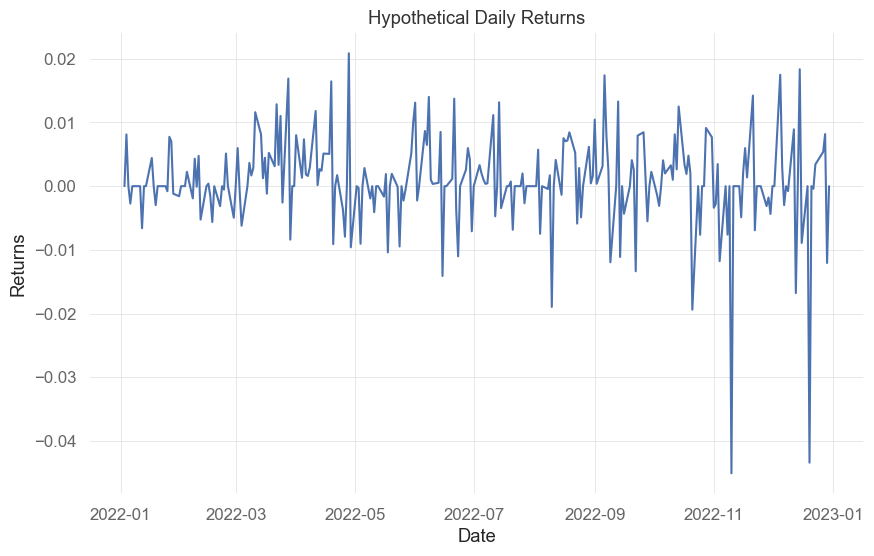

In [248]:
# Create the line chart
sns.lineplot(x="time", y="returns", data=data)

# Customize the plot
plt.title("Hypothetical Daily Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.grid(True)

# Show the plot
plt.show()


In [249]:
# Define the benchmark 



[*********************100%***********************]  1 of 1 completed


                           Strategy
-------------------------  ----------
Start Period               2022-01-02
End Period                 2022-12-29
Risk-Free Rate             0.0%
Time in Market             75.0%

Cumulative Return          18.69%
CAGR﹪                     12.7%

Sharpe                     1.5
Prob. Sharpe Ratio         91.91%
Smart Sharpe               1.47
Sortino                    2.03
Smart Sortino              1.99
Sortino/√2                 1.44
Smart Sortino/√2           1.41
Omega                      1.37

Max Drawdown               -9.83%
Longest DD Days            71
Volatility (ann.)          11.52%
Calmar                     1.29
Skew                       -1.71
Kurtosis                   10.98

Expected Daily %           0.07%
Expected Monthly %         1.44%
Expected Yearly %          18.69%
Kelly Criterion            16.55%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.13%
Expected Shortfall (cVaR)  -1.13%

Max Consecutive Wins       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-10-20,2022-12-21,2022-12-29,71,-9.828111,-9.791190
2,2022-04-28,2022-05-26,2022-06-06,40,-4.208845,-4.148475
3,2022-07-14,2022-08-09,2022-08-17,35,-2.951851,-2.684445
4,2022-09-13,2022-09-21,2022-10-10,28,-2.210717,-1.539600
5,2022-04-19,2022-04-25,2022-04-26,8,-1.892793,-1.108137


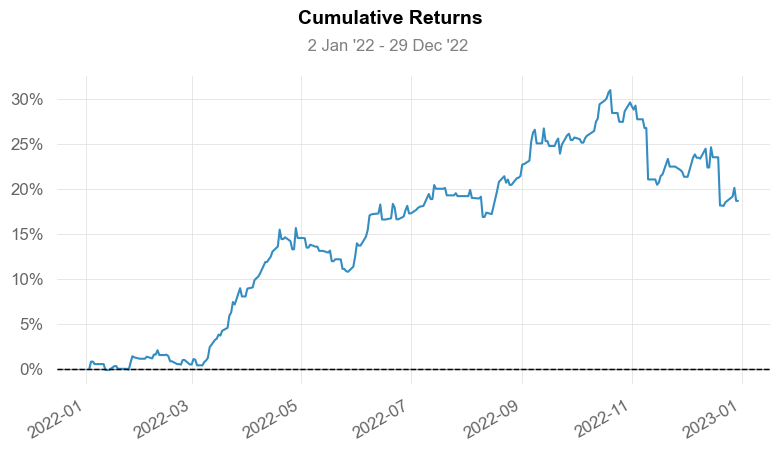

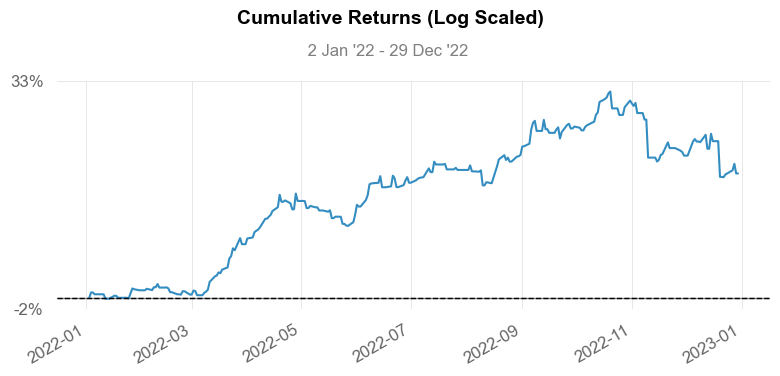

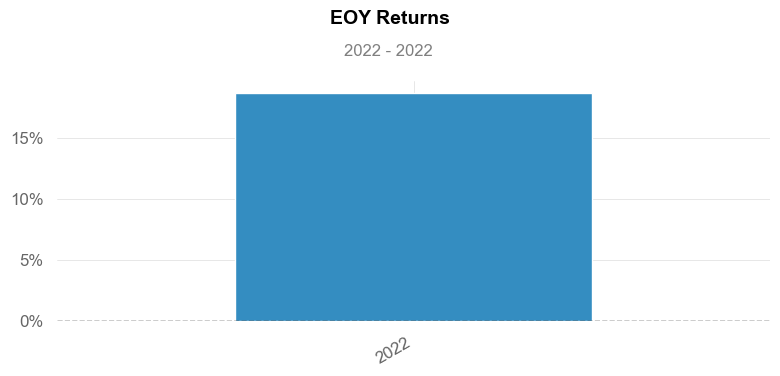

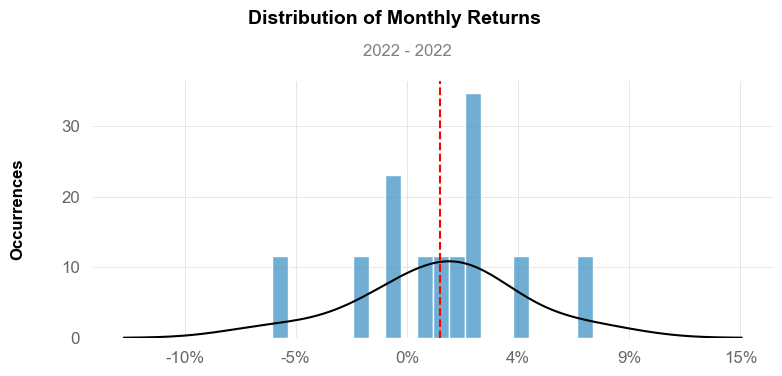

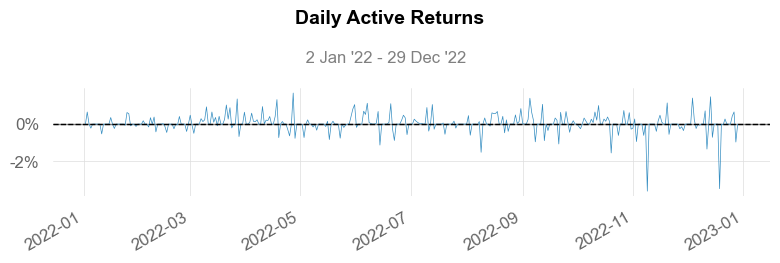

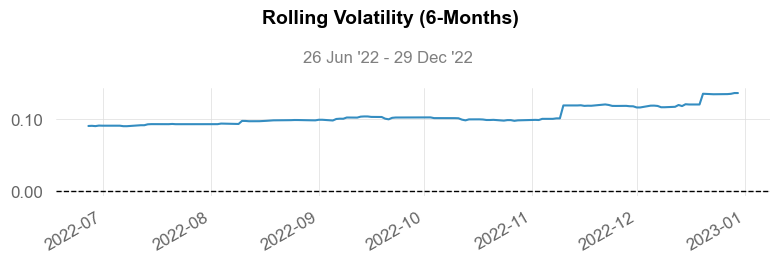

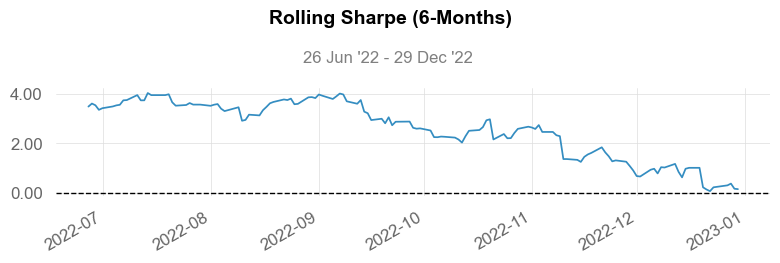

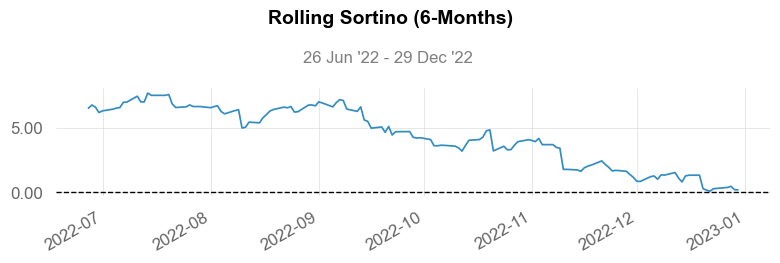

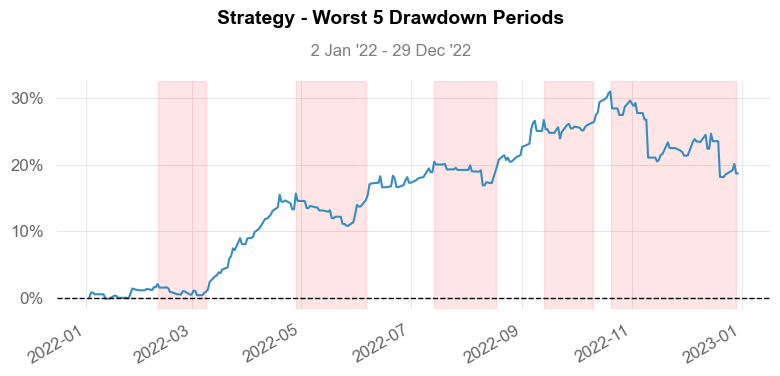

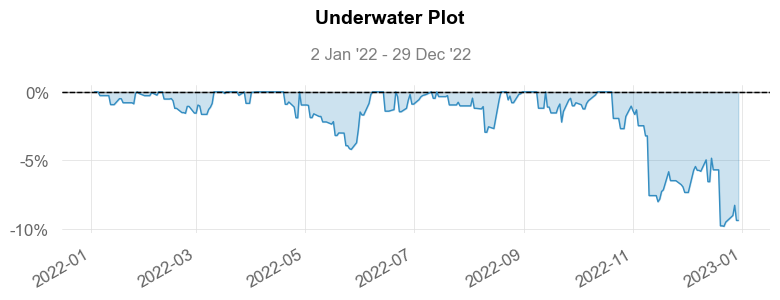

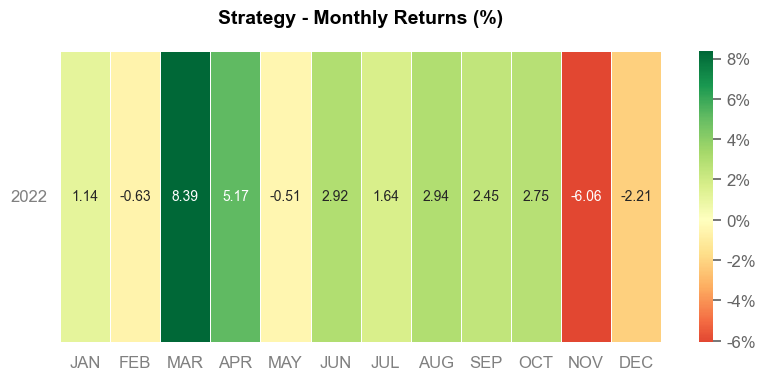

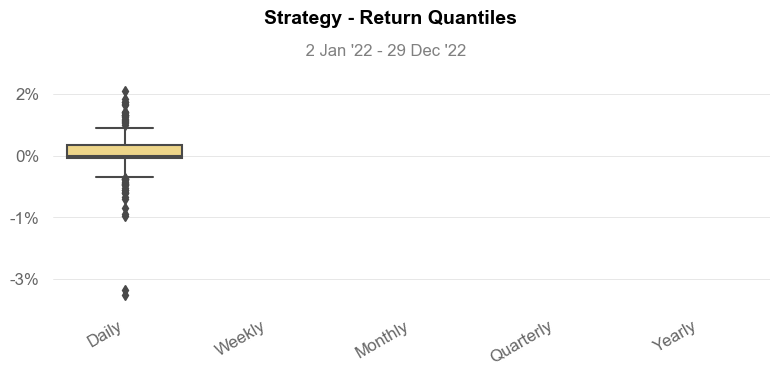

In [250]:
# Load returns, without having to convert to a series 
returns_series = data['returns']

# Optional benchmark 
#benchmark = qs.utils.download_returns('qqq')
qs.reports.full(returns_series)#, benchmark)

# Html Tearsheet
#qs.reports.html(returns_series)# , benchmark=benchmark)